# Import dan Persiapan Data

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount folder data dari Google Drive
folder_url = 'https://drive.google.com/drive/folders/1qmbmWIoX1OU0ZOsiBa0gOnyc4A39Z70N'
gdown.download_folder(folder_url, quiet=False)

# Sesuaikan path file Anda
file_path = '/content/data/cpu.xlsx'
data = pd.read_excel(file_path)

# Pastikan kolom datetime sudah dalam format datetime
data['datetime'] = pd.to_datetime(data['datetime'])

# Set datetime sebagai index
data.set_index('datetime', inplace=True)

# Periksa data yang hilang
print(data.isnull().sum())

Retrieving folder contents


Processing file 1OzlxJILf97R7ShBLs-RrjQs4P7alJC5H transaction.xlsx
Processing file 1vDAHnidQmXFnJxa5u9n_-5DLDa-3ddKY instruction.xlsx
Processing file 1RdfxDmTnT6RBpxIwl63_xnT8gII6jdPp cpu.xlsx


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1OzlxJILf97R7ShBLs-RrjQs4P7alJC5H
To: /content/data/transaction.xlsx
100%|██████████| 7.21M/7.21M [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vDAHnidQmXFnJxa5u9n_-5DLDa-3ddKY
To: /content/data/instruction.xlsx
100%|██████████| 9.65k/9.65k [00:00<00:00, 13.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RdfxDmTnT6RBpxIwl63_xnT8gII6jdPp
To: /content/data/cpu.xlsx
100%|██████████| 120k/120k [00:00<00:00, 45.9MB/s]
Download completed


cpu utilization percentage    0
dtype: int64


# EDA (Exploratory Data Analysis)

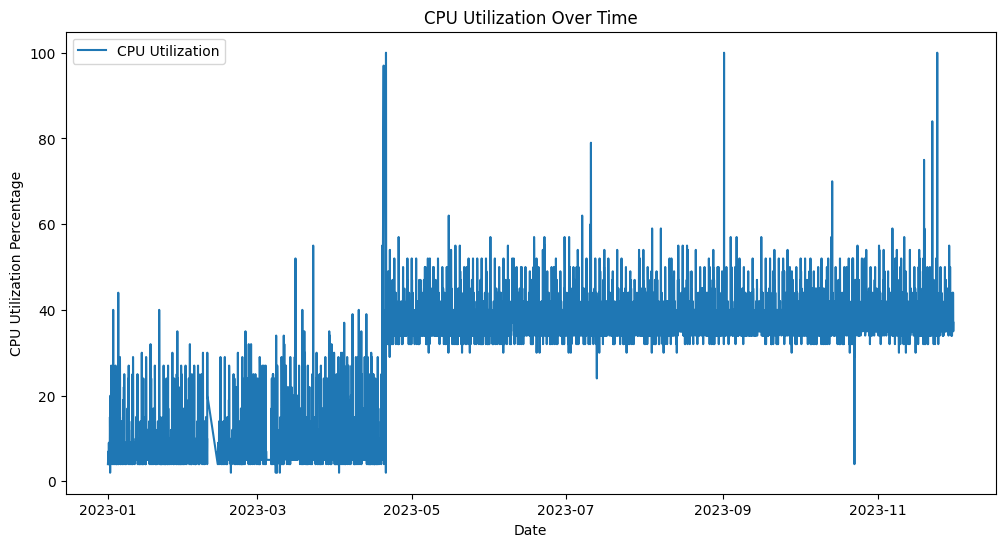

In [ ]:
# Plot data time series
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['cpu utilization percentage'], label='CPU Utilization')
plt.title('CPU Utilization Over Time')
plt.xlabel('Date')
plt.ylabel('CPU Utilization Percentage')
plt.legend()
plt.show()

# Training Model

## Membagi Data Training dan testing

In [ ]:
# Bagi data menjadi training dan testing
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[0:train_size], data[train_size:len(data)]

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 6277
Test data length: 1570


In [ ]:
print(train_data.tail())  # Pastikan ini adalah akhir data training
print(test_data.head())   # Pastikan ini adalah awal data testing


                     cpu utilization percentage
datetime                                       
2023-09-25 19:00:00                          34
2023-09-25 20:00:00                          37
2023-09-25 21:00:00                          40
2023-09-25 22:00:00                          40
2023-09-25 23:00:00                          44
                     cpu utilization percentage
datetime                                       
2023-09-26 00:00:00                          37
2023-09-26 01:00:00                          35
2023-09-26 02:00:00                          35
2023-09-26 03:00:00                          42
2023-09-26 04:00:00                          37


## Training dengan SARIMA

In [ ]:
# SARIMA Model
sarima_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit(disp=False)

# Prediksi untuk data testing
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# Hitung metrik evaluasi
mse_sarima = mean_squared_error(test_data, sarima_forecast)
rmse_sarima = np.sqrt(mse_sarima)
mad_sarima = mean_absolute_error(test_data, sarima_forecast)

print(f"SARIMA MSE: {mse_sarima}")
print(f"SARIMA RMSE: {rmse_sarima}")
print(f"SARIMA MAD: {mad_sarima}")

SARIMA MSE: 44.88457267678008
SARIMA RMSE: 6.69959496363624
SARIMA MAD: 5.5656533338088945


## Training dengan Moving Average (MA)

In [ ]:
# Moving Average Model
window_size = 24  # Gunakan 24 jam sebagai window
ma_forecast = np.convolve(train_data.values.flatten(), np.ones(window_size)/window_size, mode='valid')

# Sesuaikan panjang prediksi dengan test data
ma_forecast = ma_forecast[-len(test_data):]

# Hitung metrik evaluasi
mse_ma = mean_squared_error(test_data, ma_forecast)
rmse_ma = np.sqrt(mse_ma)
mad_ma = mean_absolute_error(test_data, ma_forecast)

print(f"Moving Average MSE: {mse_ma}")
print(f"Moving Average RMSE: {rmse_ma}")
print(f"Moving Average MAD: {mad_ma}")

Moving Average MSE: 27.511286933828732
Moving Average RMSE: 5.24512029736485
Moving Average MAD: 3.5356422505307847


## Training dengan S-curved Trend Model

In [ ]:
# S-curved Trend Model (Logistic Growth Model)
from scipy.optimize import curve_fit

def s_curve(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

# Fit model
x = np.arange(len(train_data))
popt, _ = curve_fit(s_curve, x, train_data.values.flatten(), maxfev=10000) # changed train_data.flatten() to train_data.values.flatten()

# Prediksi untuk data testing
x_test = np.arange(len(train_data), len(train_data) + len(test_data))
s_curve_forecast = s_curve(x_test, *popt)

# Hitung metrik evaluasi
mse_s_curve = mean_squared_error(test_data, s_curve_forecast)
rmse_s_curve = np.sqrt(mse_s_curve)
mad_s_curve = mean_absolute_error(test_data, s_curve_forecast)

print(f"S-curved Trend Model MSE: {mse_s_curve}")
print(f"S-curved Trend Model RMSE: {rmse_s_curve}")
print(f"S-curved Trend Model MAD: {mad_s_curve}")

S-curved Trend Model MSE: 26.610715112311755
S-curved Trend Model RMSE: 5.158557464283184
S-curved Trend Model MAD: 3.6763420581820117


## Training dengan LSTM

In [ ]:
# LSTM Model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        # Use .iloc for positional indexing
        a = dataset.iloc[i:(i + look_back), 0].values # extracts values as numpy array
        X.append(a)
        Y.append(dataset.iloc[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, y_train, batch_size=1, epochs=1)

# Prediksi untuk data testing
lstm_forecast = model_lstm.predict(X_test)

# Hitung metrik evaluasi
mse_lstm = mean_squared_error(y_test, lstm_forecast)
rmse_lstm = np.sqrt(mse_lstm)
mad_lstm = mean_absolute_error(y_test, lstm_forecast)

print(f"LSTM MSE: {mse_lstm}")
print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM MAD: {mad_lstm}")

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 108s 17ms/step - loss: 71.0397
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
LSTM MSE: 25.961660385131836
LSTM RMSE: 5.095258618081307
LSTM MAD: 3.488595485687256


In [ ]:
# Menyimpan Model yang Telah Di-Train
# SARIMA
sarima_fit.save('sarima_model.pkl')

# Moving Average
np.save('ma_forecast.npy', ma_forecast)

# S-curved Trend Model
np.save('s_curve_params.npy', popt)

# LSTM
model_lstm.save('lstm_model.h5')

# Prediksi Data Testing

## Hasil Prediksi Data Testing (20% Data Terbaru)

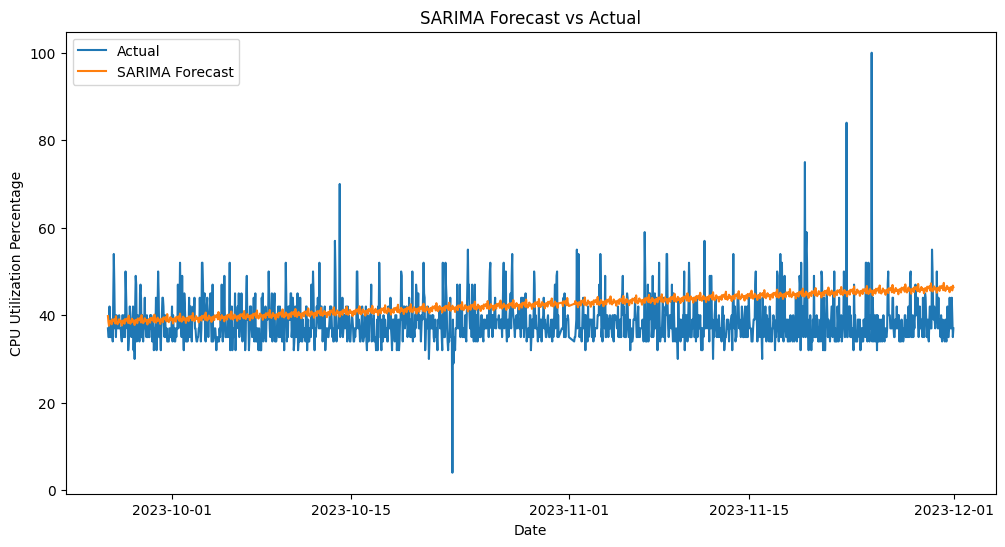

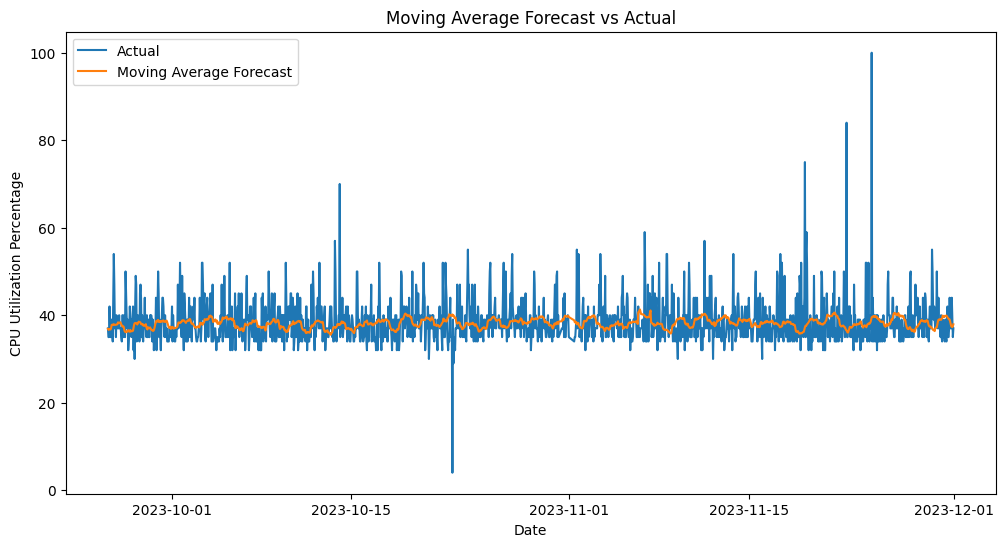

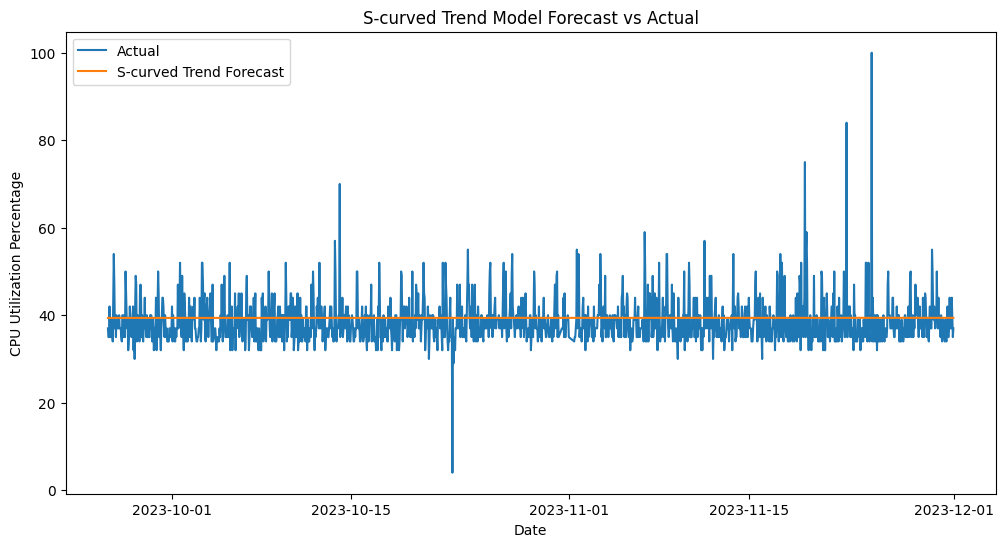

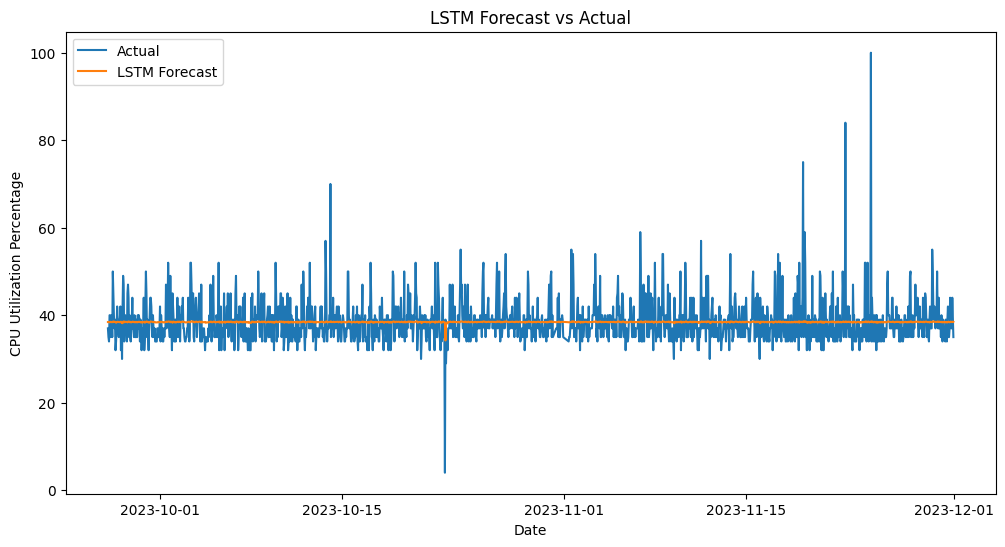

In [ ]:
# Visualisasi SARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['cpu utilization percentage'], label='Actual')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CPU Utilization Percentage')
plt.legend()
plt.show()

# Visualisasi Moving Average
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['cpu utilization percentage'], label='Actual')
plt.plot(test_data.index, ma_forecast, label='Moving Average Forecast')
plt.title('Moving Average Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CPU Utilization Percentage')
plt.legend()
plt.show()

# Visualisasi S-curved Trend Model
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['cpu utilization percentage'], label='Actual')
plt.plot(test_data.index, s_curve_forecast, label='S-curved Trend Forecast')
plt.title('S-curved Trend Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CPU Utilization Percentage')
plt.legend()
plt.show()

# Visualisasi LSTM
plt.figure(figsize=(12, 6))
# Corrected line: use test_data.index from the first entry of y_test to match the lengths
plt.plot(test_data.index[look_back:look_back+len(y_test)], y_test, label='Actual')
plt.plot(test_data.index[look_back:look_back+len(y_test)], lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CPU Utilization Percentage')
plt.legend()
plt.show()